In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
#IMPORTS
import numpy as np
import os
import pandas as pd
import matplotlib.pyplot as plt
import datetime

plt.rcParams['font.size'] = 20

In [3]:
# GET THE DATA
package_folder = os.path.dirname(os.path.dirname(os.path.dirname(os.getcwd())))
data_folder = os.path.join(package_folder, 'data')

selected_columns = ['mean_NW2_C02_rpm', 'mean_NW2_C02_pitch', 'mean_NW2_C02_power',
       'mean_NW2_C02_windspeed', 'sin_mean_NW2_C02_yaw',
       'cos_mean_NW2_C02_yaw', 'sin_mean_NW2_C02_winddirection',
       'cos_mean_NW2_C02_winddirection',
       'mvbc_WandelaarBuoy_Wave_height',
       'mvbc_WandelaarBuoy_Average_wave_period',
       'mvbc_WandelaarMeasuringpile_Tide_TAW',
       'mvbc_WandelaarMeasuringpile_Air_pressure',
       'mvbc_WandelaarMeasuringpile_Air_temperature'
       ]

loc = 'nw2'
turbine = 'c02'
mode = 'whirling'

In [4]:
from src.data.utils import get_input_data
from src.data.harmonics import *

data = get_input_data(data_folder, loc, turbine)
harmonics_data = harmonics(data['turbine_data'].filter(regex='rpm'), [1,3,6, 9])

In [5]:
from src.data.harmonics import *
from src.data.make_dataset import create_input_data
from src.data.utils import get_input_data
from src.data.modal_data import *

selected_data= pd.read_parquet(os.path.join(data_folder, 'processed','nw2',mode, turbine+'_' + mode + '_selected_data.parquet'))
mpe_ss_data = get_mpe_data(data['turbine_data'], 'SS', loc, turbine)

X = create_input_data(data_folder, loc, turbine)
X = X[selected_columns].loc[:datetime.datetime(2023, 6, 1, tzinfo=datetime.timezone.utc)]
y_train = selected_data['mean_frequency']

common_indices = X.dropna().index.intersection(y_train.dropna().index)
y_train = y_train.loc[common_indices]
X_train = pd.DataFrame(index = y_train.index)
for column in selected_columns:
    X_train[column] = X[column].loc[common_indices]

dropped mvbc columns:  {'mvbc_WandelaarMeasuringpile_Relative_humidity', 'mvbc_WandelaarBuoy_Sea_water_temperature'}


In [6]:
test_data_path = '_'.join([loc, turbine, 'SS2', 'test_data.parquet'])
test_turbine_data = pd.read_parquet(os.path.join(data_folder, 'raw', loc, test_data_path))
#remove duplicated index
duplicated_indices = test_turbine_data.index.duplicated(keep='first')
test_turbine_data = test_turbine_data[~duplicated_indices]
test_turbine_data.index = pd.to_datetime(test_turbine_data.index, utc=True)

wandelaar_weather_station_data = pd.read_parquet(os.path.join(data_folder,'external', loc, 'test_wandelaar_weather_data.parquet'))
westhinder_weather_station_data = pd.read_parquet(os.path.join(data_folder,'external', loc, 'test_westhinder_weather_data.parquet'))

mvbc_test_data = wandelaar_weather_station_data.copy()
mvbc_test_data[mvbc_test_data.filter(regex='Tide').columns] = westhinder_weather_station_data.filter(regex='Tide').values
#mvbc_test_data.rename(columns={mvbc_test_data.filter(regex='Tide').columns[0] :westhinder_weather_station_data.filter(regex='Tide').columns[0]}, inplace=True)
mvbc_test_data.isna().sum()
mvbc_test_data.index = pd.to_datetime(mvbc_test_data.index, utc=True)

smart_tracked_test = pd.read_parquet(os.path.join(data_folder, 'processed', loc,'test_2023_06_12_predictions', '_'.join([loc, turbine, mode]) +'smart_tracked_modes.parquet'))

In [7]:
import pandas as pd
from dw_config.location import Turbine
from dw_database.utils import DynawindFrame

nw2c02_df = pd.read_parquet(r"C:\Users\Max\Documents\OWI_LAB\Code\DCE_EOVnorm\dce_eov_normalisation\data\raw\nw2\nw2c02.parquet")
nw2c02_df.drop('location', axis=1, inplace=True)
def rename_mpe_cols(data: pd.DataFrame, replcement:str = 'mode_'):
    for col in data.columns:
        if 'mpe_' in col:
            data.rename(columns={col: col.replace('mpe_', replcement)}, inplace=True)
    return data
            
nw2c02_df = rename_mpe_cols(nw2c02_df, replcement='mode_')

In [8]:
#location = Location('NW2C02')
location = Turbine('NW2C02')
dwf_ = DynawindFrame(df=nw2c02_df, location=location)

In [9]:
#load the predictions of the training data
predictions_df_training = pd.read_parquet(os.path.join(data_folder, 'processed', loc, mode, turbine+'_'+mode+'_predictions.parquet'))
smart_tracked_modes_training = pd.read_parquet(os.path.join(data_folder, 'processed', loc,mode, turbine+'_'+mode+'_smart_tracked_modes.parquet'))

In [10]:
dwf_smart_tracked = DynawindFrame(nw2c02_df.loc[smart_tracked_modes_training.index], location=location)
dwf_training = DynawindFrame(nw2c02_df.loc[selected_data.index], location=location)

In [11]:
nw2c02_test = rename_mpe_cols(test_turbine_data.drop('location', axis=1), replcement='mode_')
nw2c02_test

,mean_NW2_C02_rpm,mean_NW2_C02_yaw,std_NW2_C02_pitch,mean_NW2_C02_pitch,mean_NW2_C02_power,std_NW2_C02_windspeed,mean_NW2_C02_windspeed,mean_NW2_C02_winddirection,mode_NW2_C02_FA,mode_NW2_C02_SS,...,min_NW2_C02_NAC_ACC_SS,rms_NW2_C02_NAC_ACC_FA,rms_NW2_C02_NAC_ACC_SS,std_NW2_C02_NAC_ACC_FA,std_NW2_C02_NAC_ACC_SS,mean_NW2_C02_NAC_ACC_FA,mean_NW2_C02_NAC_ACC_SS,rms1p_NW2_C02_NAC_ACC_Z,rms1p_NW2_C02_NAC_ACC_FA,rms1p_NW2_C02_NAC_ACC_SS
timestamp,,,,,,,,,,,,,,,,,,,,,
2023-06-01 00:00:00+00:00,10.445,16.338,0.831241,-3.525,8118.208,0.754,11.391,17.150,"[{'algorithm': 'lscf', 'mean_damping': 9.21373...","[{'algorithm': 'lscf', 'mean_damping': 12.5724...",...,-0.036635,0.010305,0.011513,0.010305,0.011513,0.0,0.0,0.000431,0.003753,0.004629
2023-06-01 00:10:00+00:00,10.445,20.535,1.015521,-2.854,6843.520,1.023,10.609,22.353,"[{'algorithm': 'lscf', 'mean_damping': 7.28535...","[{'algorithm': 'lscf', 'mean_damping': 6.77687...",...,-0.033817,0.009921,0.010211,0.009921,0.010211,0.0,0.0,0.000430,0.003918,0.003613
2023-06-01 00:20:00+00:00,10.445,24.843,0.709950,-2.070,5771.776,1.277,10.180,24.032,"[{'algorithm': 'lscf', 'mean_damping': 7.23372...","[{'algorithm': 'lscf', 'mean_damping': 10.8954...",...,-0.036501,0.010950,0.010467,0.010950,0.010467,0.0,0.0,0.000427,0.003839,0.004551
2023-06-01 00:30:00+00:00,10.445,25.179,0.956972,-2.826,6920.320,1.156,11.129,24.060,"[{'algorithm': 'lscf', 'mean_damping': 11.3884...","[{'algorithm': 'lscf', 'mean_damping': 2.64039...",...,-0.038860,0.011446,0.011084,0.011446,0.011084,0.0,0.0,0.000452,0.004023,0.004891
2023-06-01 00:40:00+00:00,10.445,24.955,0.644423,-2.042,5688.768,0.922,10.141,25.095,"[{'algorithm': 'lscf', 'mean_damping': 1.71208...","[{'algorithm': 'lscf', 'mean_damping': 1.95700...",...,-0.042127,0.011552,0.011688,0.011552,0.011688,0.0,0.0,0.000444,0.003902,0.004729
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-11-28 23:20:00+00:00,8.356,262.307,3.330953,11.302,2606.016,1.086,11.836,264.042,"[{'algorithm': 'lscf', 'mean_damping': 3.91734...","[{'algorithm': 'lscf', 'mean_damping': 2.64405...",...,-0.046832,0.012763,0.014760,0.012763,0.014760,0.0,0.0,0.000147,0.001332,0.001579
2023-11-28 23:30:00+00:00,9.848,266.392,1.561828,7.470,3989.888,0.988,11.230,265.748,"[{'algorithm': 'lscf', 'mean_damping': 6.39674...","[{'algorithm': 'lscf', 'mean_damping': 1.79096...",...,-0.050363,0.011258,0.014364,0.011258,0.014364,0.0,0.0,0.000278,0.002491,0.002950
2023-11-28 23:40:00+00:00,9.848,268.266,1.449121,8.617,3952.384,0.977,12.008,266.532,"[{'algorithm': 'lscf', 'mean_damping': 4.84534...","[{'algorithm': 'lscf', 'mean_damping': 3.06192...",...,-0.049815,0.010782,0.013090,0.010782,0.013090,0.0,0.0,0.000290,0.002430,0.003452


In [12]:
dwf_test = DynawindFrame(nw2c02_test, location=location)
dwf_smart_tracked_test = DynawindFrame(nw2c02_test.loc[smart_tracked_test.index], location=location)

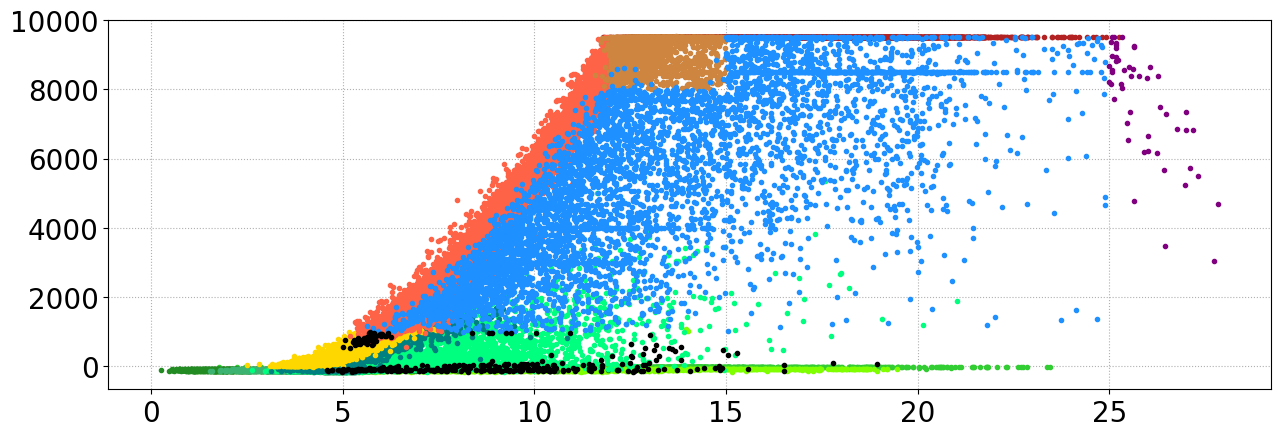

In [13]:
dwf_.plot(x='mean_windspeed',y='mean_power', color_by_case=True, marker='.', linestyle='')
plt.gcf().set_figwidth(15)

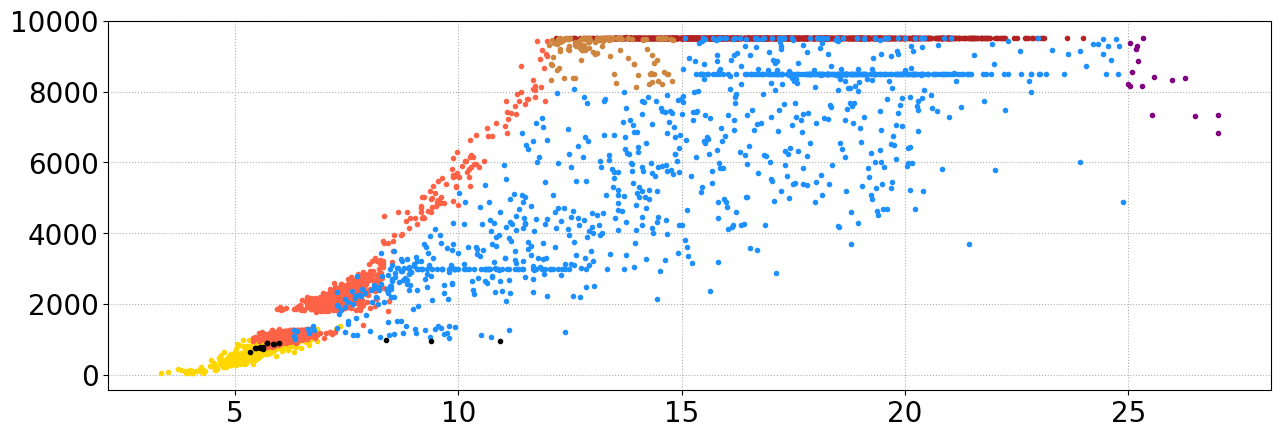

In [14]:
dwf_training.plot(x='mean_windspeed',y='mean_power', color_by_case=True, marker='.', linestyle='')
plt.gcf().set_figwidth(15)

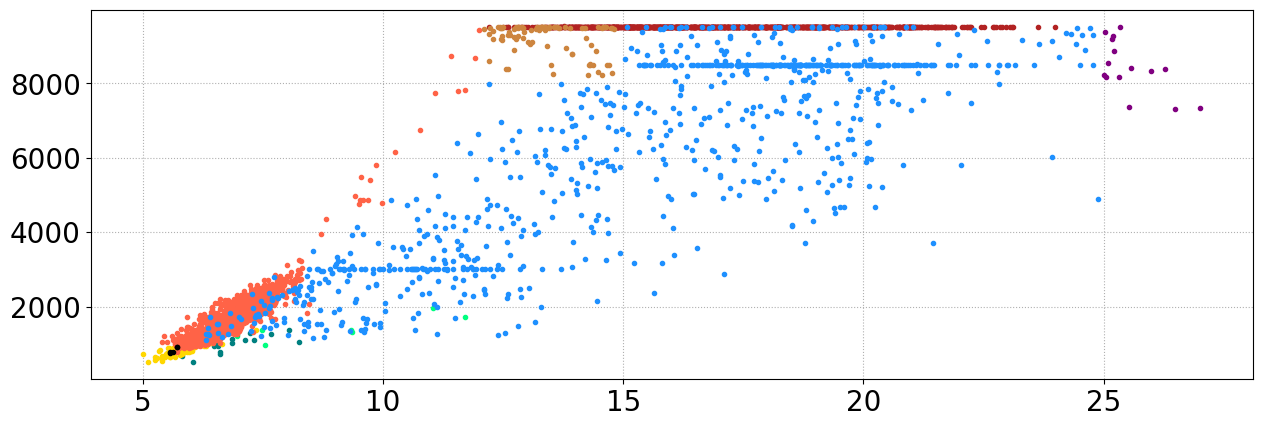

In [15]:
dwf_smart_tracked.plot(x='mean_windspeed',y='mean_power', color_by_case=True, marker='.', linestyle='')
plt.gcf().set_figwidth(15)

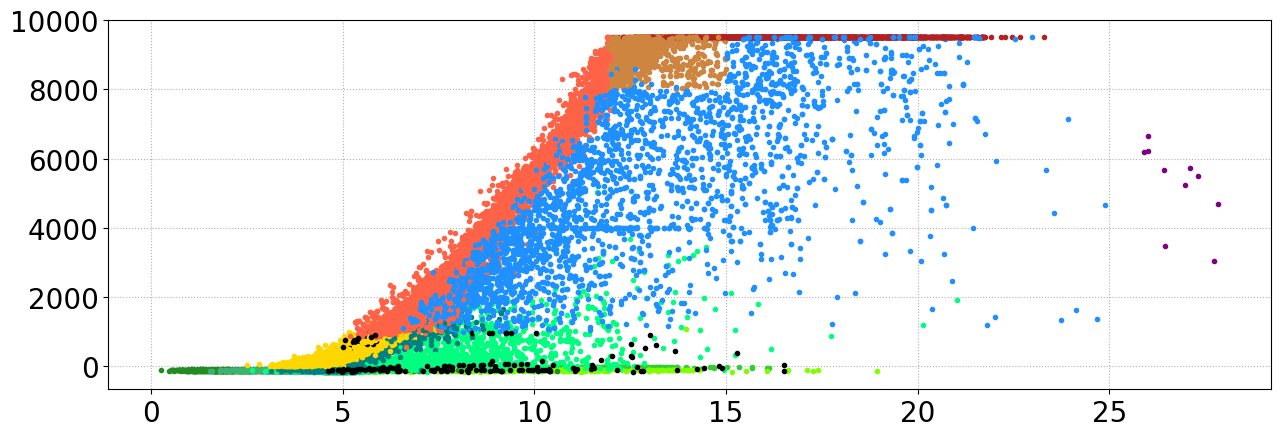

In [16]:
dwf_test.plot(x='mean_windspeed',y='mean_power', color_by_case=True, marker='.', linestyle='')
plt.gcf().set_figwidth(15)

dwf_smart_tracked_test.plot(x='mean_windspeed',y='mean_power', color_by_case=True, marker='.', linestyle='')
plt.gcf().set_figwidth(15)

init All data
here All data [0.         0.04908739 0.09817477 0.14726216 0.19634954 0.24543693
 0.29452431 0.3436117 ]
init Training data
here Training data [0.         0.06041524 0.12083049 0.18124573 0.24166097 0.30207622
 0.36249146 0.4229067  0.48332195 0.54373719 0.60415243 0.66456768
 0.72498292]
init Smart tracked
here Smart tracked [0.         0.08055366 0.16110732 0.24166097 0.32221463 0.40276829
 0.48332195 0.5638756  0.64442926 0.72498292 0.80553658 0.88609024
 0.96664389]


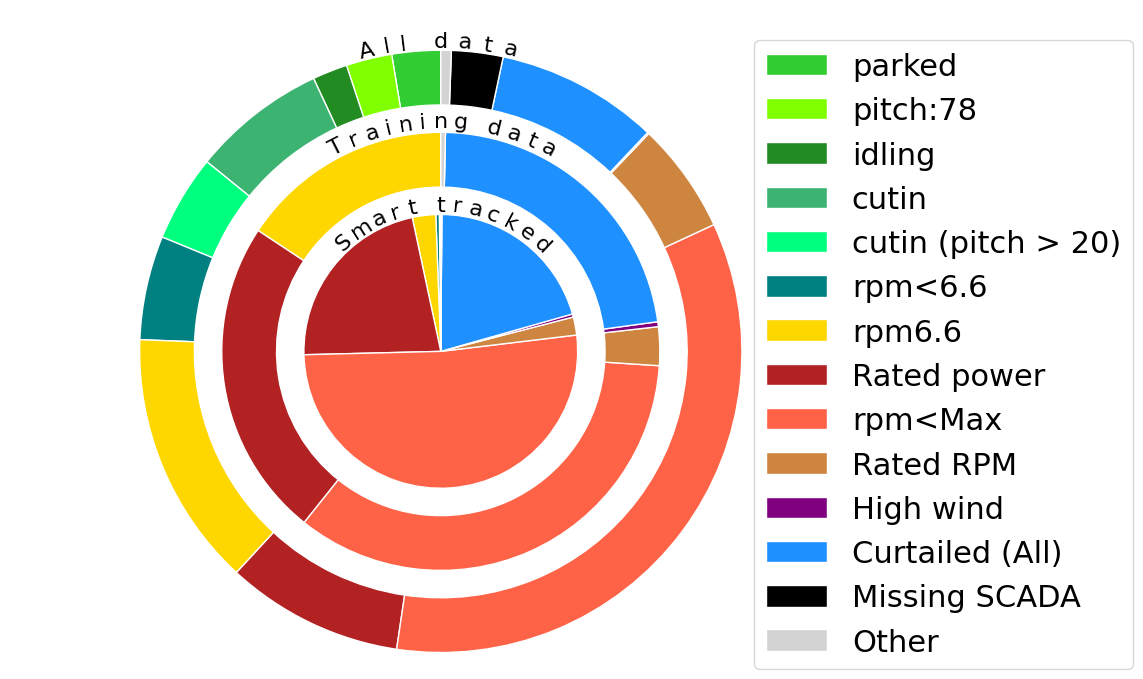

In [17]:
import matplotlib.pyplot as plt
from matplotlib.textpath import TextPath
from matplotlib.patches import PathPatch
from matplotlib.font_manager import FontProperties
def place_text_around_circle(ax, text, center, radius, mid_angle=0, fontsize=16, arc_len = np.pi):
    print('init', text)
    fontprops = FontProperties(family="sans-serif", style='normal', size=fontsize)
    arc_per_char = arc_len / len(text)  # Evenly space characters around the circle
    angles =  arc_per_char * np.arange(len(text))
    arc_length = 0  # Initialize the arc length
    angles_ = []
    print('here', text, angles)
    for char, angle in zip(text, angles):
        # Measure the width of the character
        tp = TextPath((0, 0), char, prop=fontprops)
        bb = tp.get_extents()
        char_width = bb.width/fontsize  # Adjust by fontsize
        # Convert character width from pixels to radians
        char_width_rad = char_width / (2*arc_len*radius**2)

        
        # Calculate the angle for this character
        if char_width_rad > 0:
            angle_ = angle + arc_length + char_width_rad/6
        else:
            angle_ = angle + arc_length
        angles_.append(angle_)
        # Increment the arc length by the width of the character
        if char_width_rad > 0:
            arc_length += char_width_rad/4

    for char, angle_ in zip(text, angles_):
        #center angles around mid_angle
        angle_ = angle_ - angles_[int(len(angles_)/2)] + mid_angle
        x = center[0] - radius * np.cos(angle_)
        y = center[1] + radius * np.sin(angle_)
        rotation = np.degrees(-angle_) + 90  # Rotate text to align with the circle
        ax.text(x, y, char, ha='center', va='center', rotation=rotation, fontsize=fontsize)

        



def plot_case_donuts(data1, data2, data3, 
                     labels=['All data','Training data','Smart tracked'], 
                     radiuses = [2.0, 1.5, 1.0],
                     mid_angles = [np.pi/4, np.pi/4, np.pi/4],
                     arc_lens = [np.pi/2, np.pi/2, np.pi/2],
                     show_percent=False, 
                     figsize=(12, 8),
                     fontsize=16):
    fig, ax = plt.subplots(figsize=figsize)
    ax.axis('equal')

    # Assuming case_stats is a method that returns a dictionary with 'Abs' and 'Perc' keys with lists as values
    case_stats1 = data1.case_stats()
    case_stats2 = data2.case_stats()
    case_stats3 = data3.case_stats()
    colors = [c.color for c in data1.case_definitions]
    colors.append('lightgrey')
    labels_ = [str(item).split(': ')[0] for item in data1.case_definitions]
    labels_.append('Other')

    # Create a pie chart for each set of data
    wedges1, texts1 = plt.pie(case_stats1['Abs'][:], colors=colors, radius=radiuses[0], wedgeprops=dict(width=0.4, edgecolor='w'), startangle=90)
    wedges2, texts2 = plt.pie(case_stats2['Abs'][:], colors=colors, radius=radiuses[1], wedgeprops=dict(width=0.4, edgecolor='w'), startangle=90)
    wedges3, texts3 = plt.pie(case_stats3['Abs'][:], colors=colors, radius=radiuses[2], wedgeprops=dict(width=1.0, edgecolor='w'), startangle=90)


    place_text_around_circle(ax, labels[0], center=(0,0), radius = radiuses[0]*1.03, mid_angle=mid_angles[0], fontsize=fontsize, arc_len = arc_lens[0])
    place_text_around_circle(ax, labels[1], center=(0,0), radius = radiuses[1]*1.05, mid_angle=mid_angles[1], fontsize=fontsize, arc_len = arc_lens[1])
    place_text_around_circle(ax, labels[2], center=(0,0), radius = radiuses[2]*1.07, mid_angle=mid_angles[2], fontsize=fontsize, arc_len = arc_lens[2])

    # Add the percentages to the wedges
    if show_percent:
        for wedge, stats in zip([wedges1, wedges2, wedges3], [case_stats1['Abs'], case_stats2['Abs'], case_stats3['Abs']]):
            for w, percent in zip(wedge, stats):
                if percent >= 2.0:
                    angle = (w.theta2 + w.theta1) / 2
                    if w.width < w.r:
                        x = (w.r - w.width/2) * 1.0 * np.cos(np.radians(angle))
                        y = (w.r - w.width/2) * 1.0 * np.sin(np.radians(angle))
                        plt.text(x, y, f'{np.round(percent)}', ha='center', va='center', fontsize=8)
                    else:
                        x = (w.r - w.width/8) * 1.0 * np.cos(np.radians(angle))
                        y = (w.r - w.width/8) * 1.0 * np.sin(np.radians(angle))
                        plt.text(x, y, f'{np.round(percent)}', ha='center', va='center', fontsize=8)
    plt.gca().set(aspect="equal")
    legend_cases = plt.legend(wedges2, labels_, bbox_to_anchor=(0.8, 0.95), loc='upper left', fontsize=22, borderaxespad=0.)

    # plt.text(-0.25, 0.2, 'Data', fontsize=20)
    # plt.text(-0.55, -0.05, 'description', fontsize=20)

    plt.gca().set(aspect="equal")
    plt.xlim(-2, 2.5)
    plt.ylim(-2, 2.5)
    plt.show()
    plt.close()

plot_case_donuts(dwf_, dwf_training, dwf_smart_tracked, radiuses = [2.2, 1.6, 1.0],  show_percent=False, mid_angles=[np.pi/2, np.pi/2, np.pi/2], arc_lens=[np.pi/8, np.pi/4, np.pi/3])

init All test data
here All test data [0.         0.03020762 0.06041524 0.09062287 0.12083049 0.15103811
 0.18124573 0.21145335 0.24166097 0.2718686  0.30207622 0.33228384
 0.36249146]
init Training data
here Training data [0.         0.06041524 0.12083049 0.18124573 0.24166097 0.30207622
 0.36249146 0.4229067  0.48332195 0.54373719 0.60415243 0.66456768
 0.72498292]
init Smart tracked test
here Smart tracked test [0.         0.05817764 0.11635528 0.17453293 0.23271057 0.29088821
 0.34906585 0.40724349 0.46542113 0.52359878 0.58177642 0.63995406
 0.6981317  0.75630934 0.81448698 0.87266463 0.93084227 0.98901991]


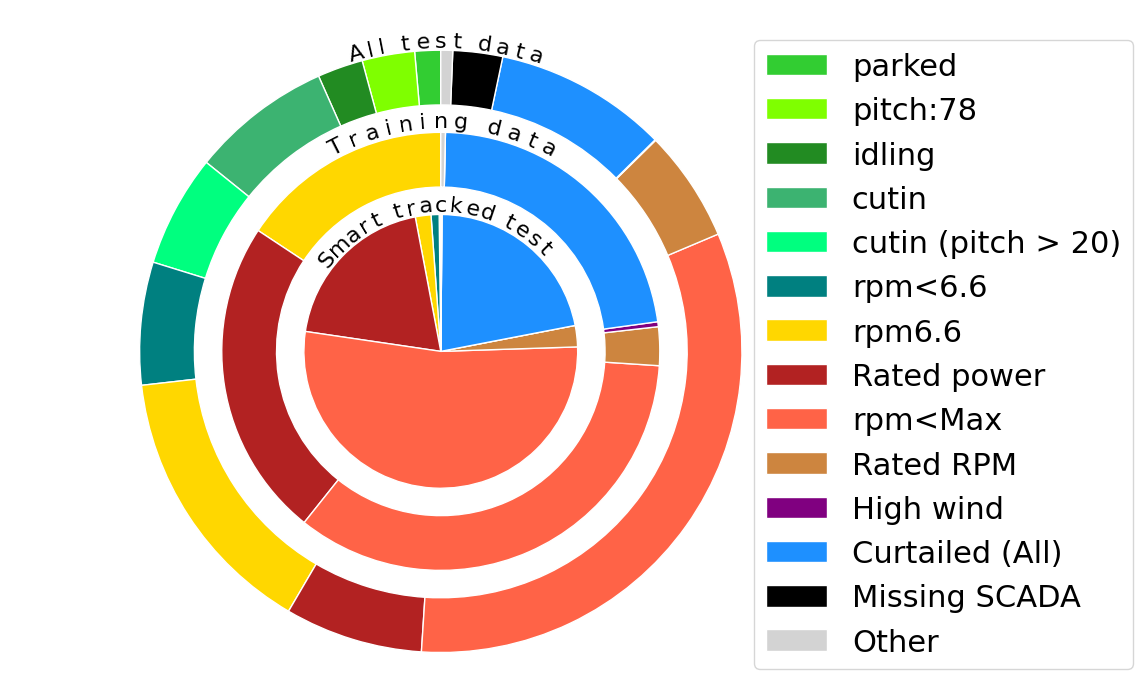

In [18]:
plot_case_donuts(dwf_test, dwf_training, dwf_smart_tracked_test, labels=['All test data','Training data','Smart tracked test'], radiuses = [2.2, 1.6, 1.0],  show_percent=False, mid_angles=[np.pi/2, np.pi/2, np.pi/2], arc_lens=[np.pi/8, np.pi/4, np.pi/3])

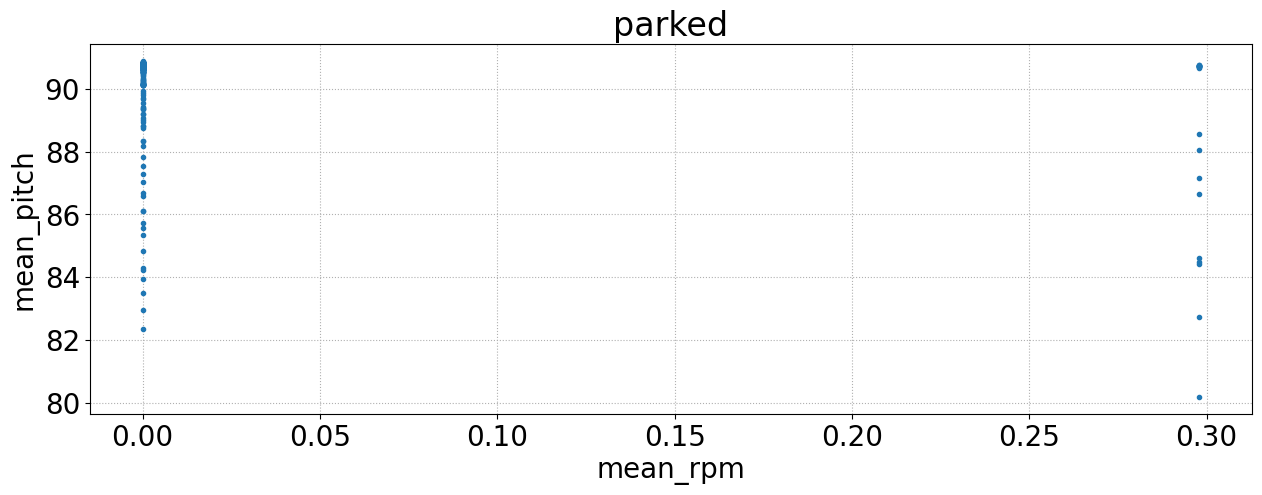

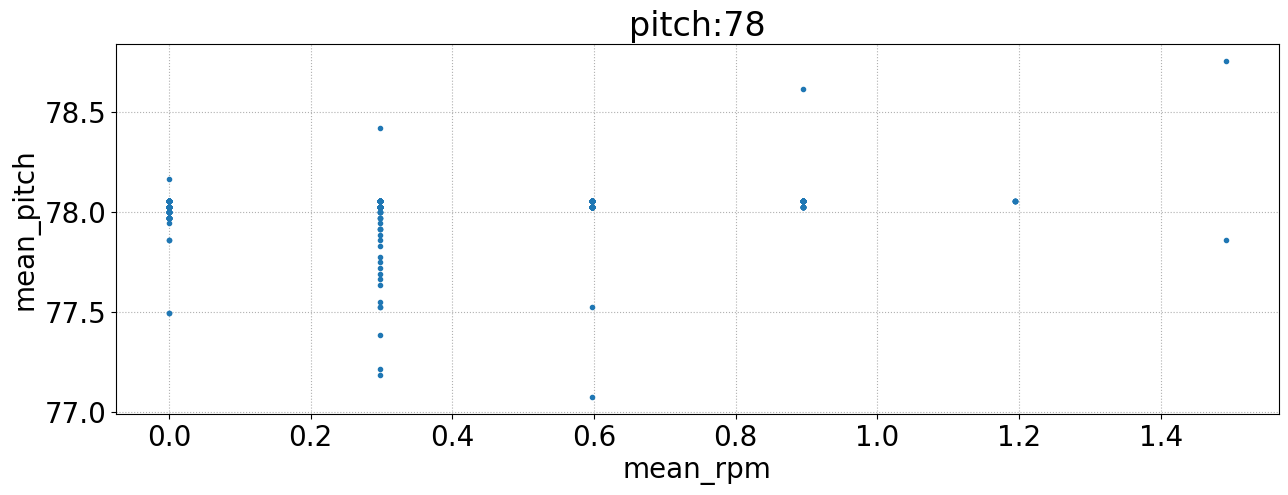

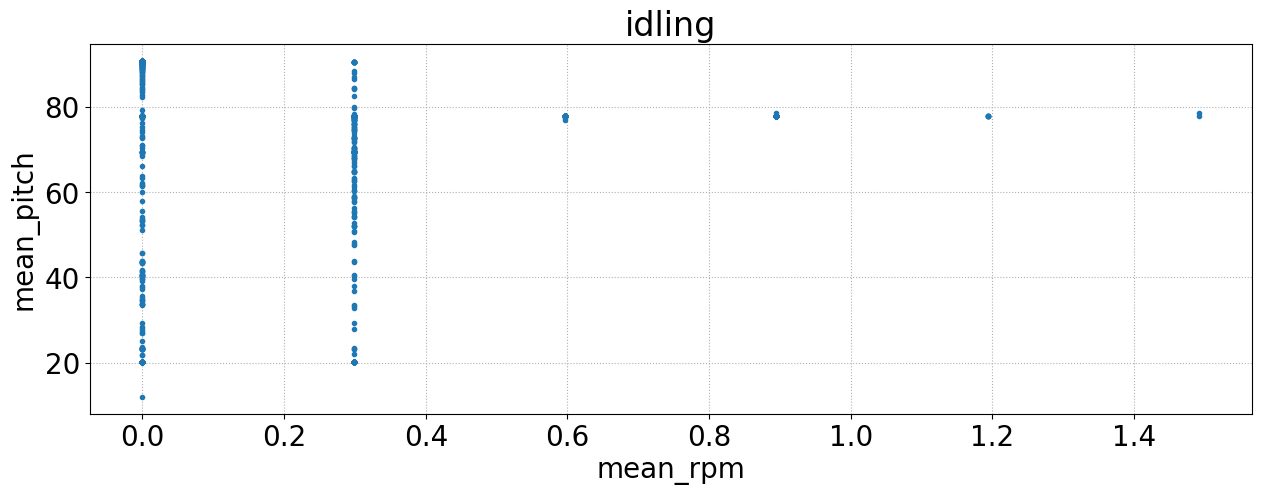

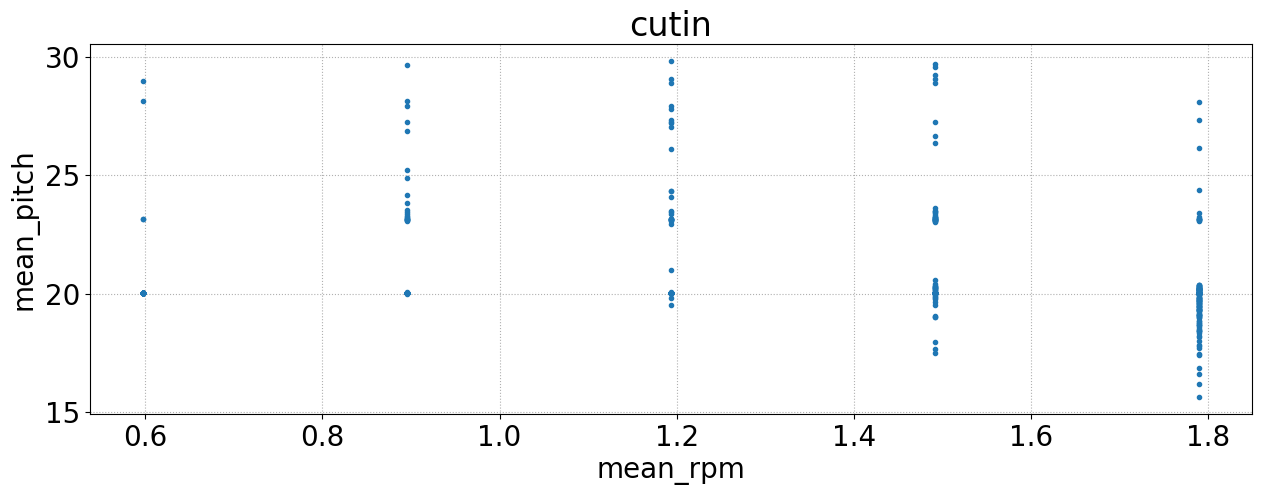

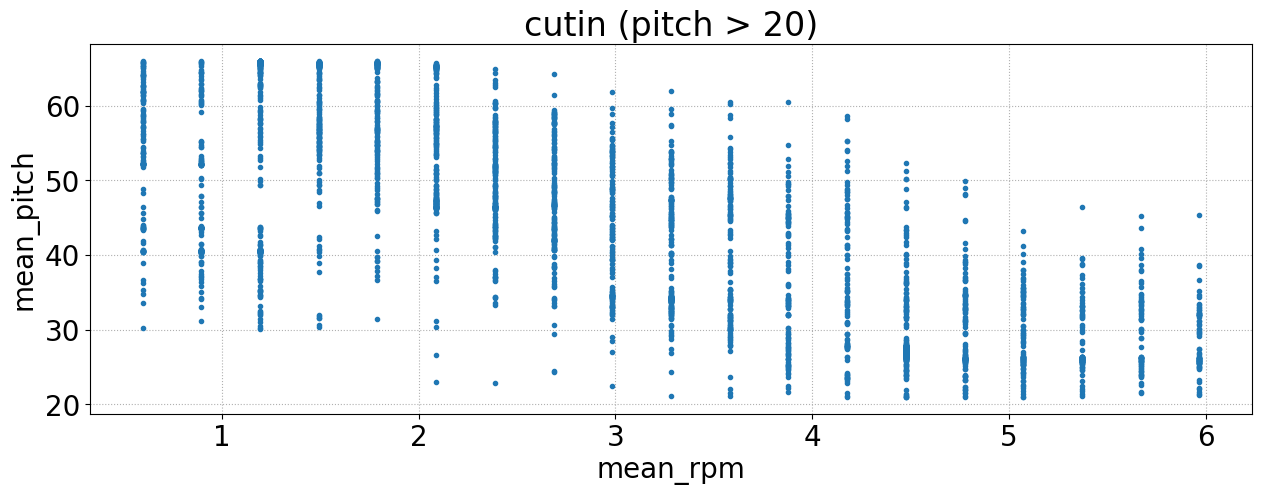

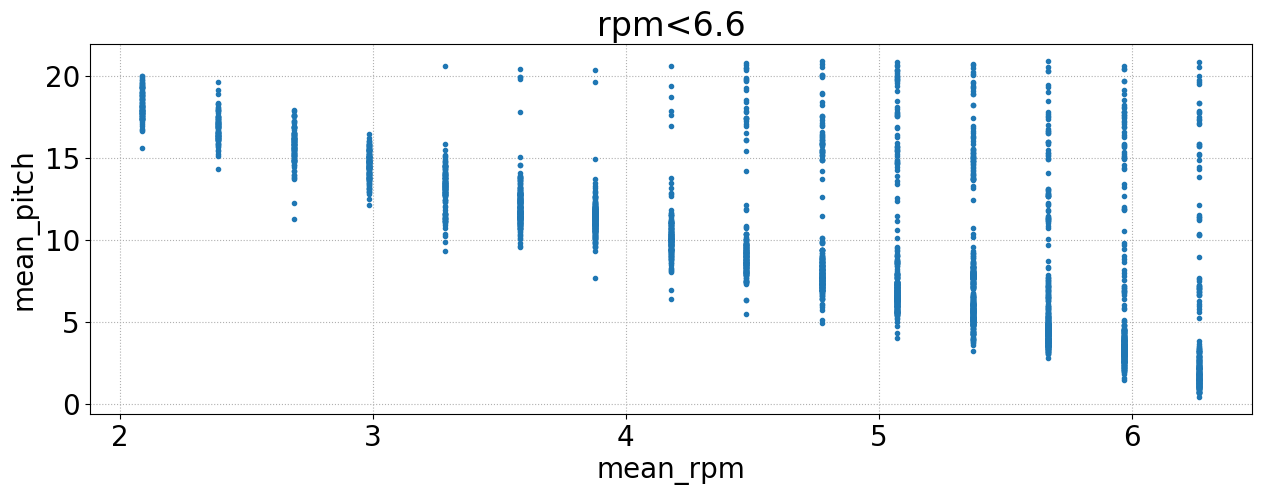

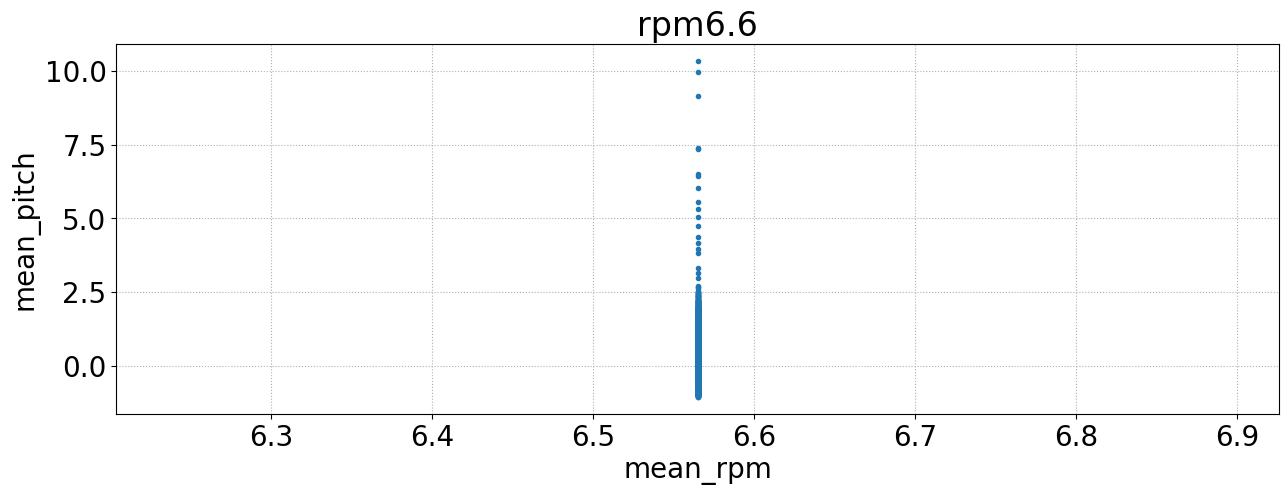

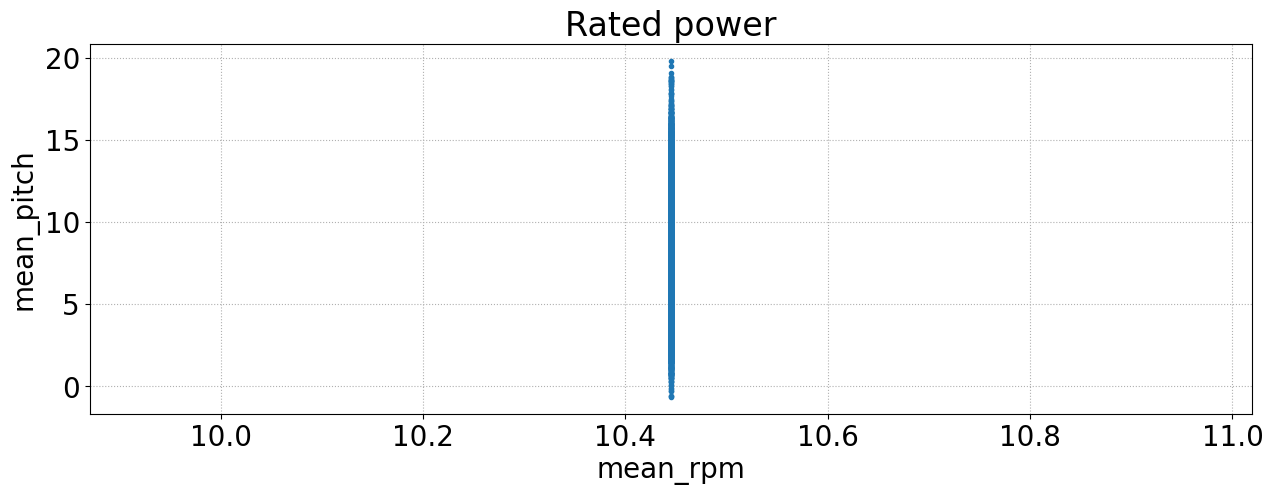

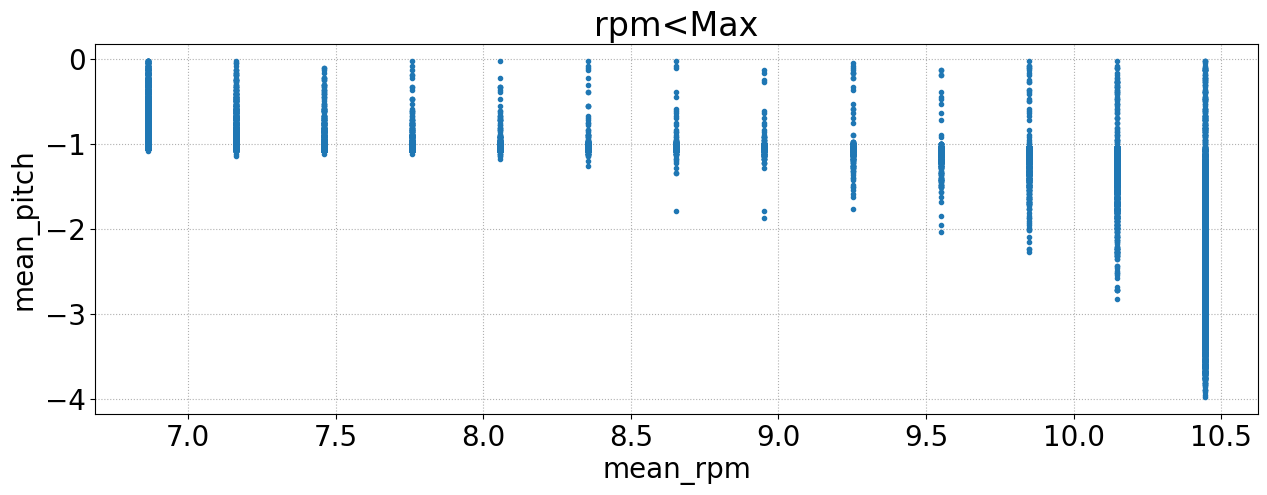

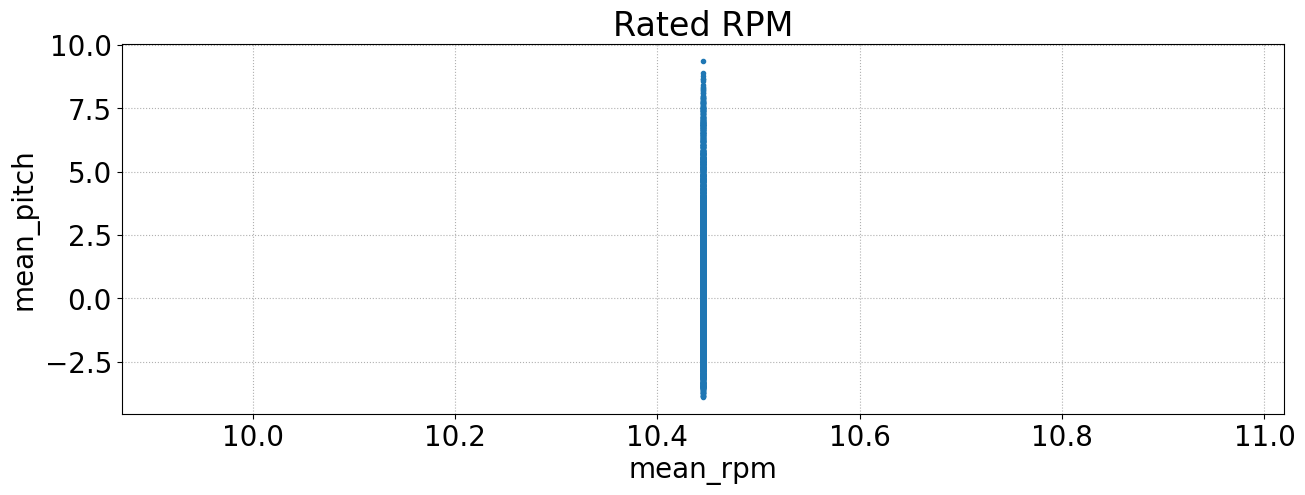

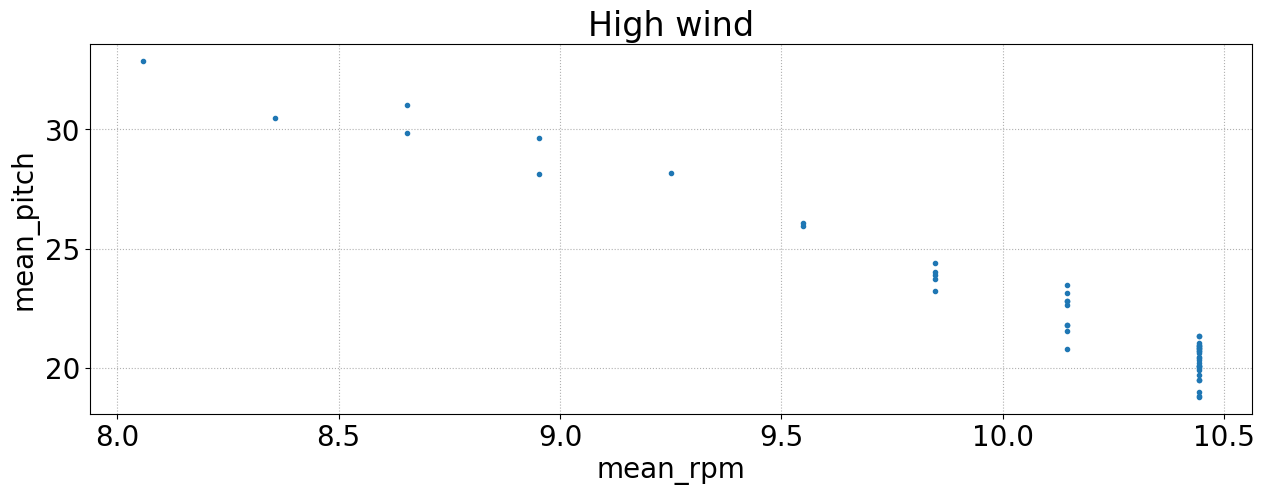

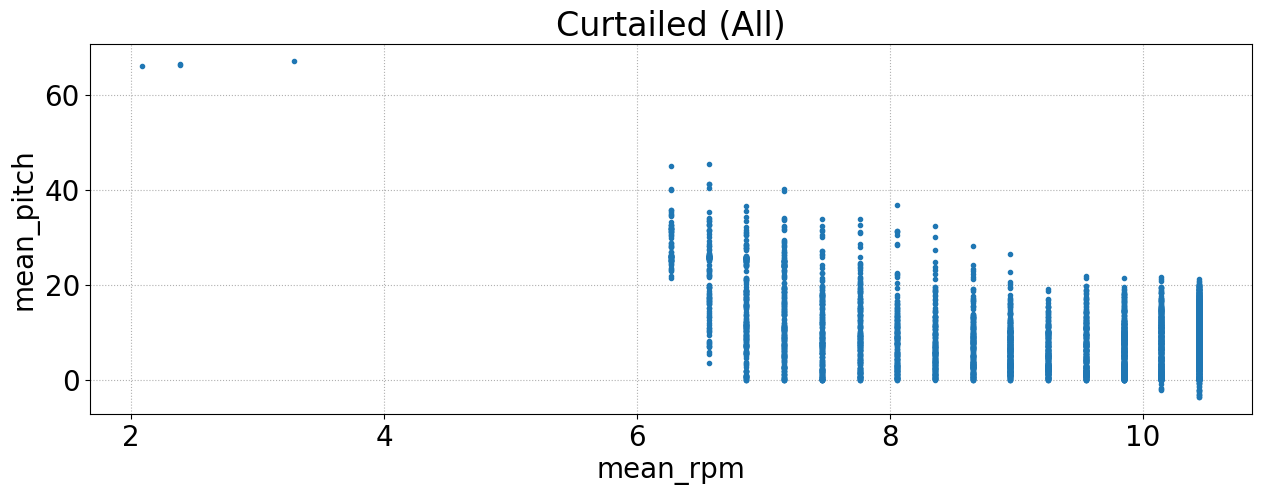

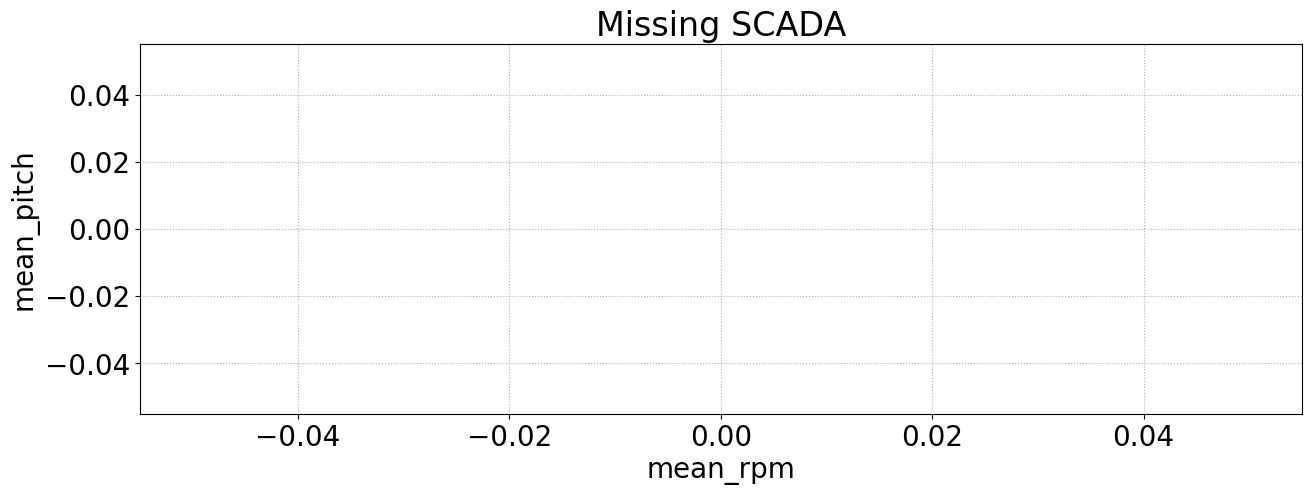

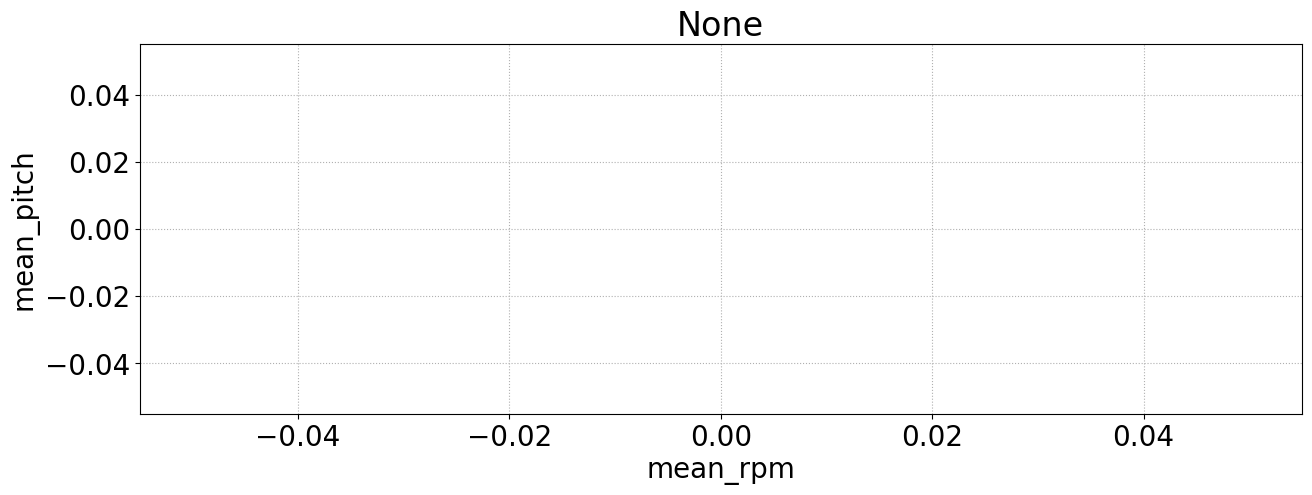

In [19]:
x = 'mean_rpm'
y = 'mean_pitch'

for caseID in dwf_.case_stats().index.tolist():
    dwf_[dwf_['caseID'] == caseID].plot(x=x,y=y, marker='.', linestyle='', label=caseID)
    plt.title(caseID)
    plt.xlabel(x)
    plt.ylabel(y)
    plt.gcf().set_figwidth(15) 
    plt.show()

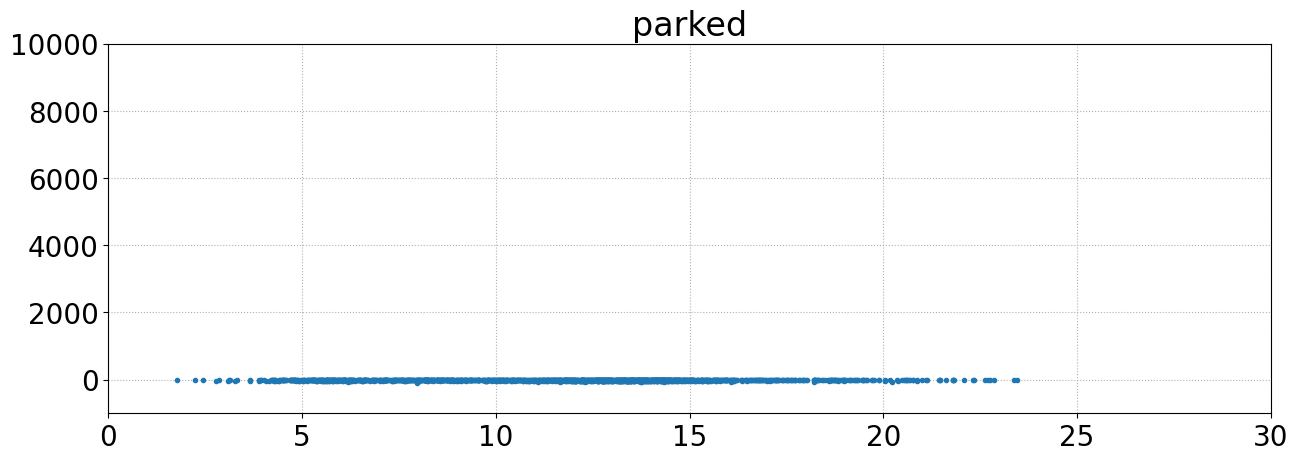

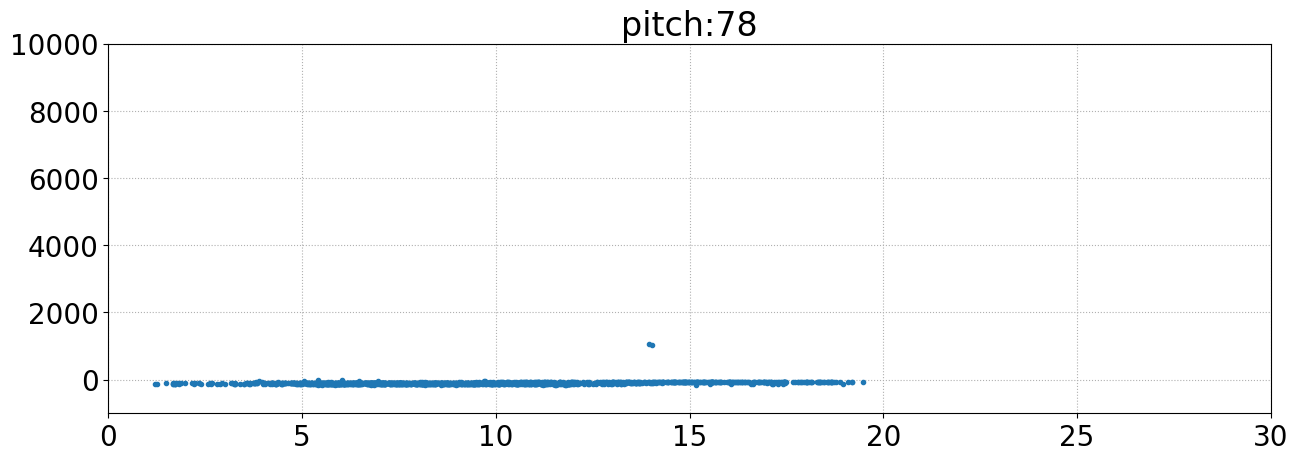

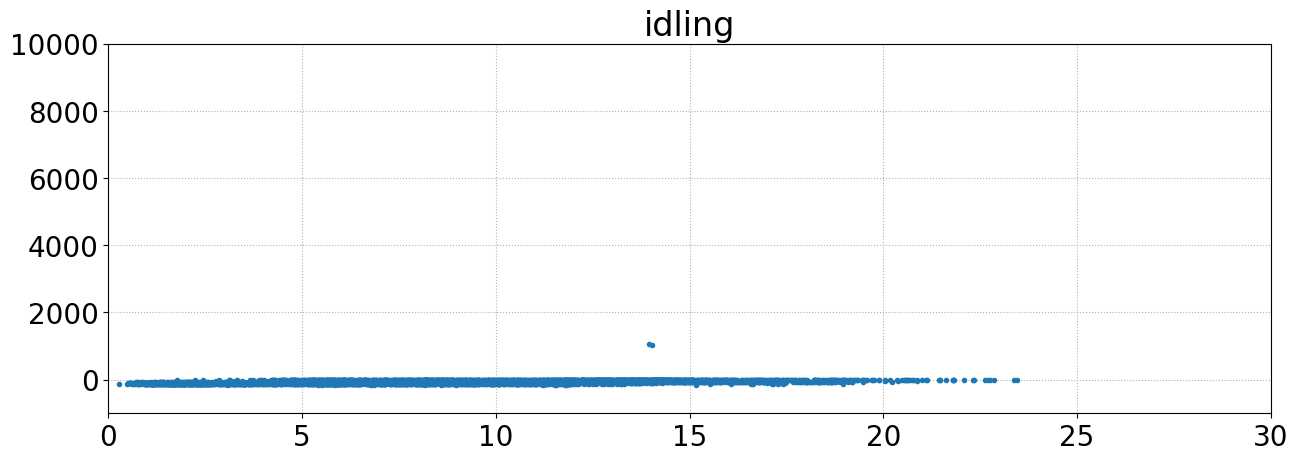

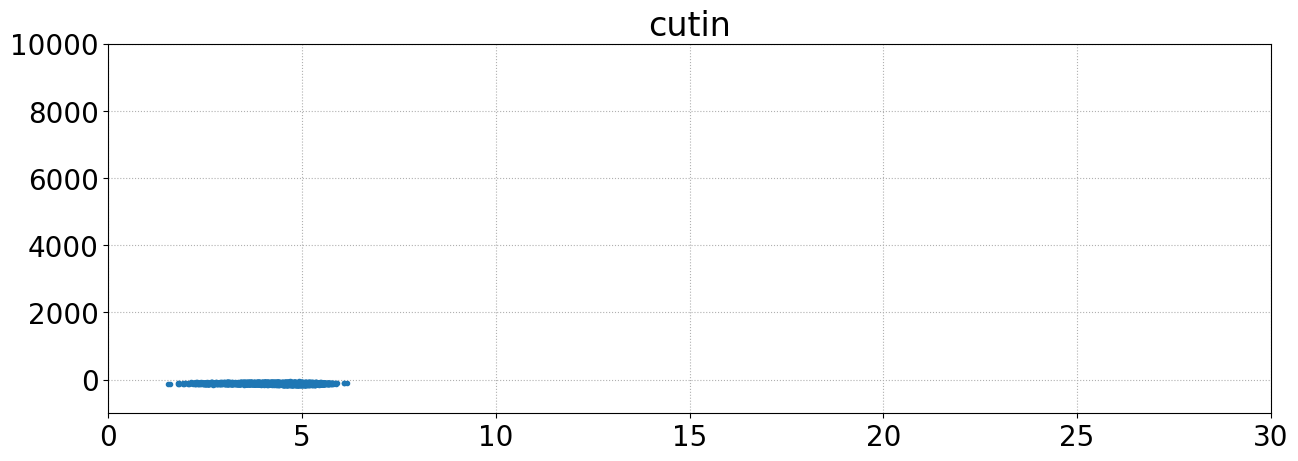

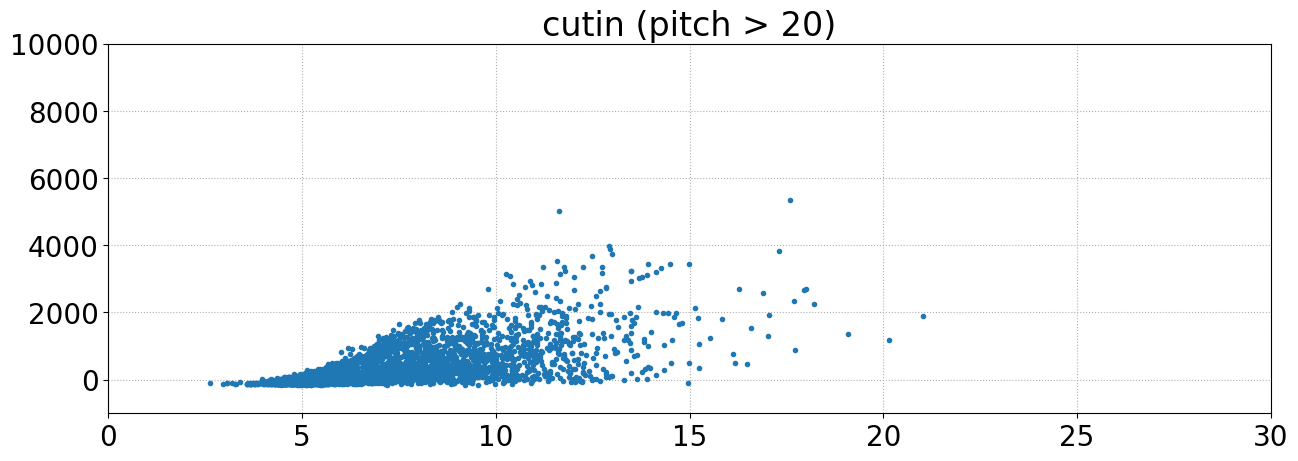

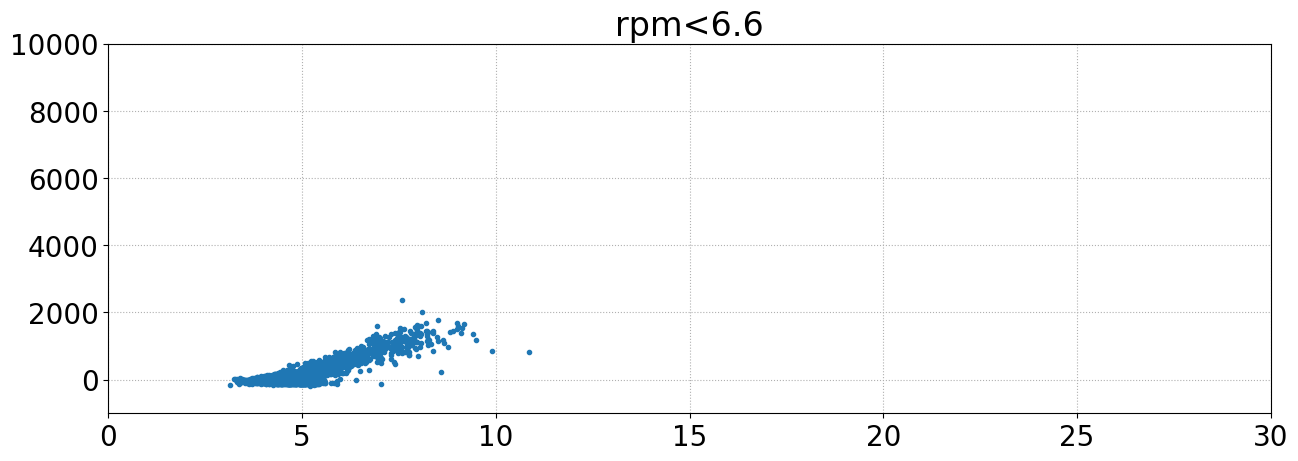

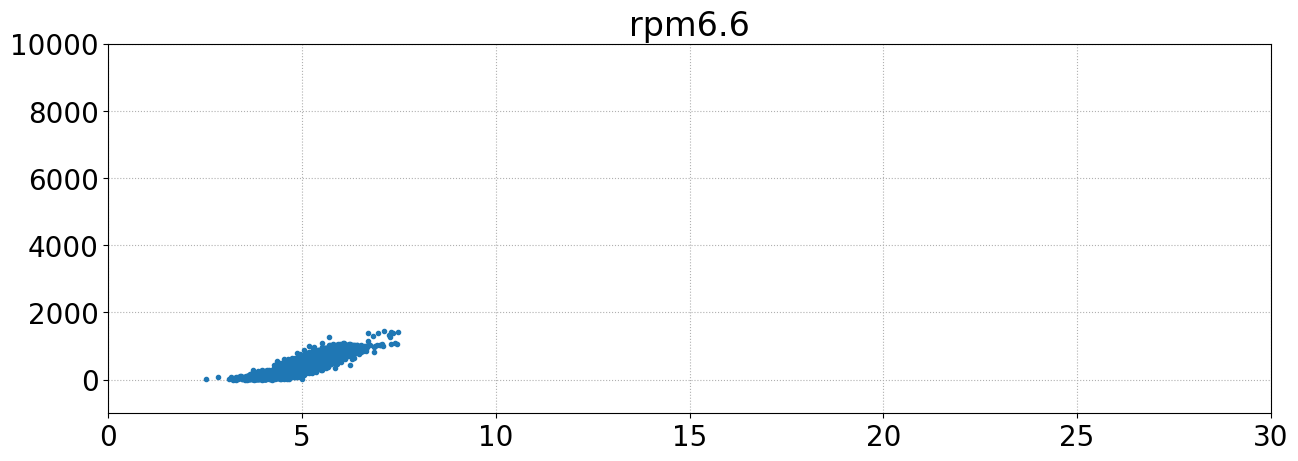

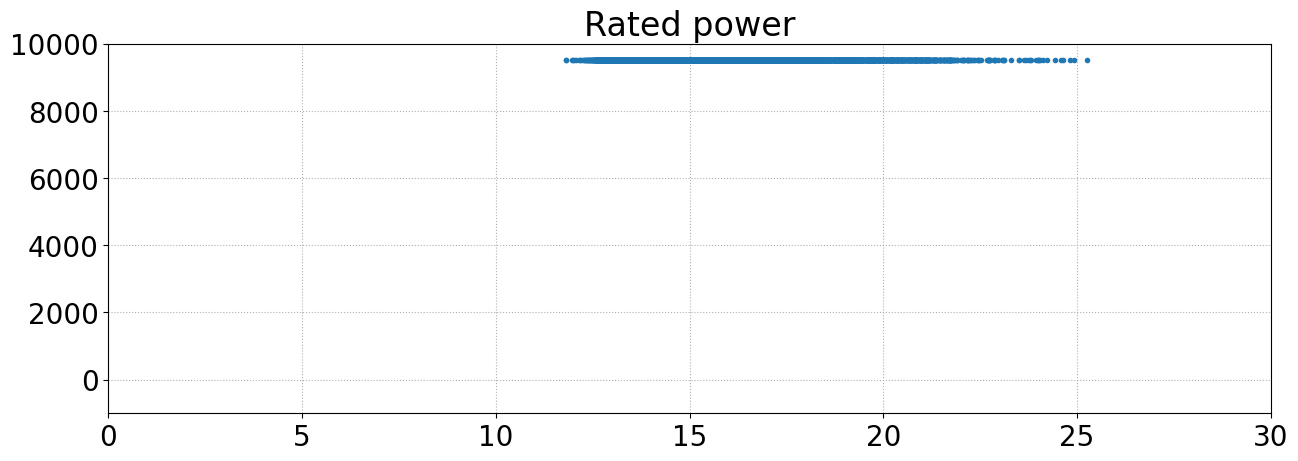

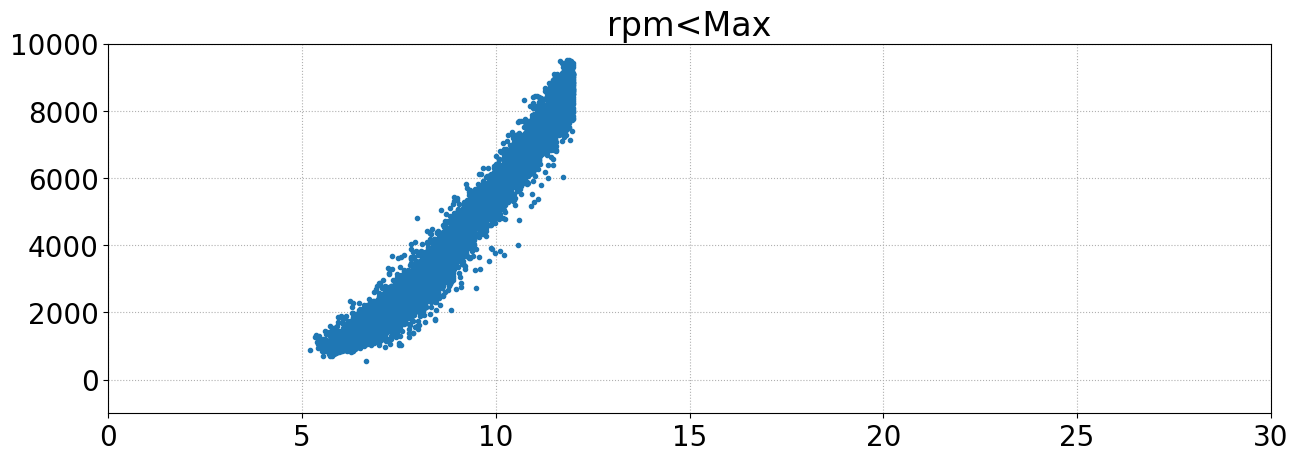

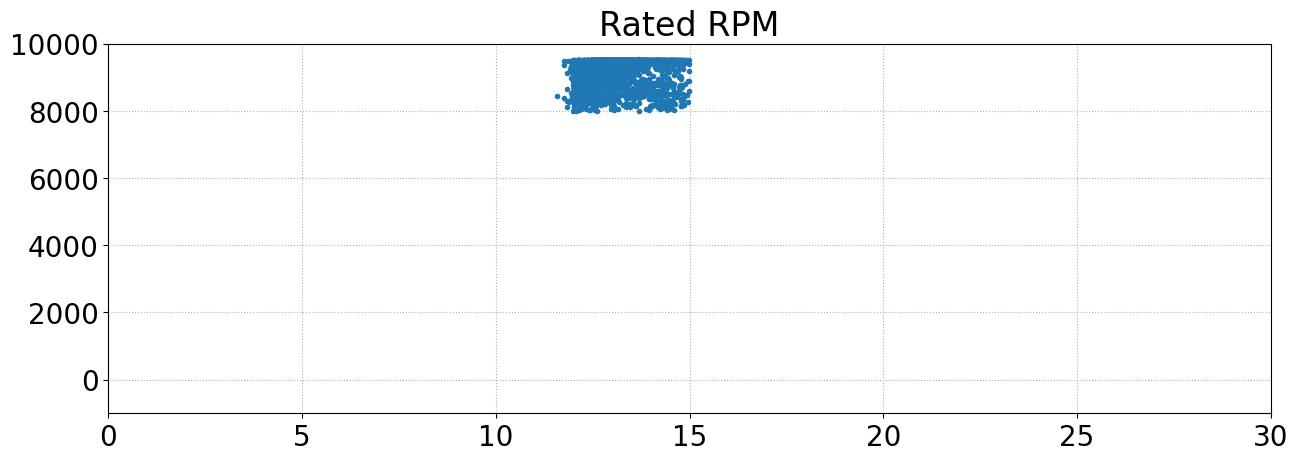

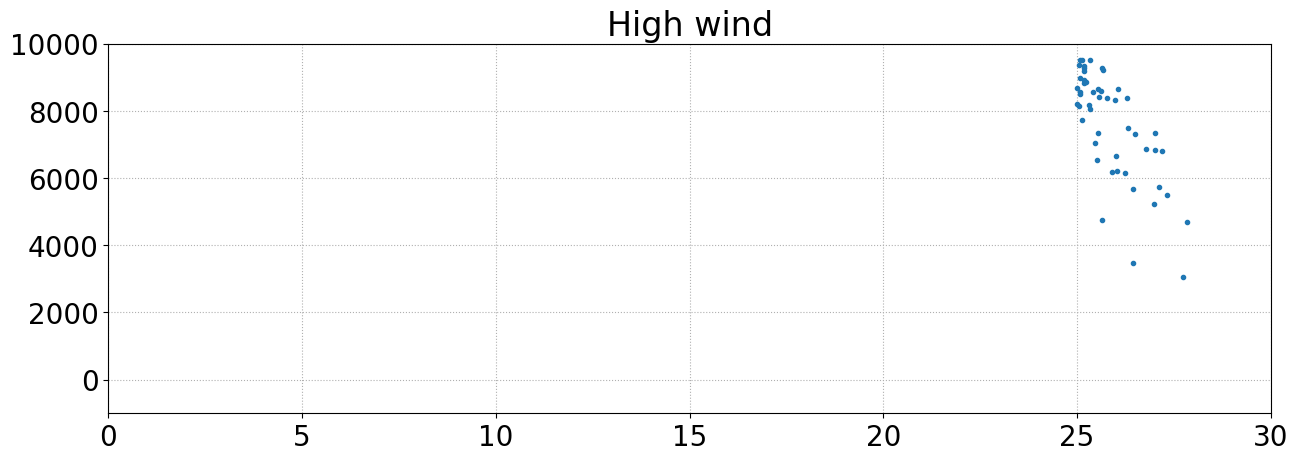

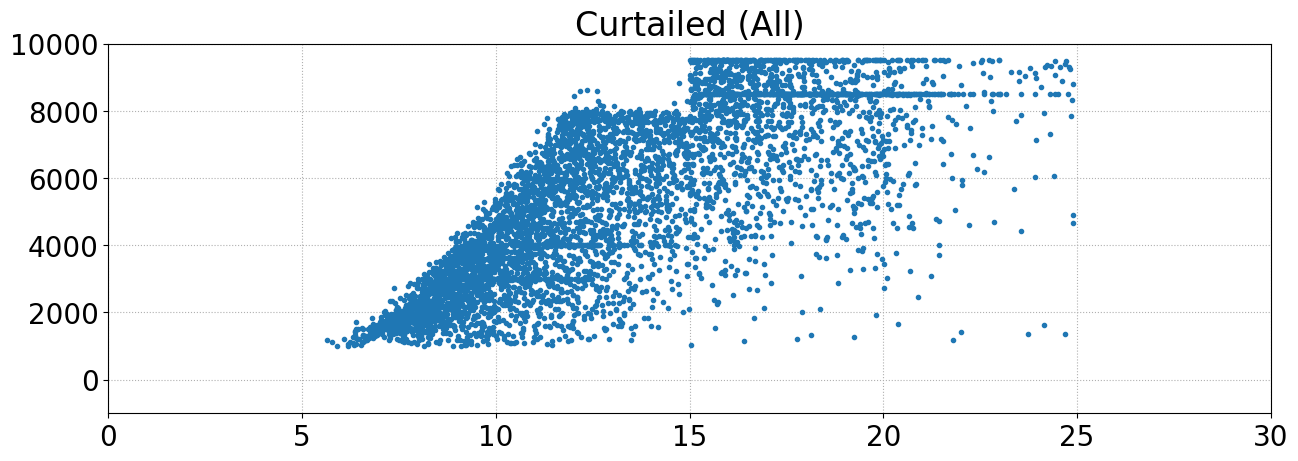

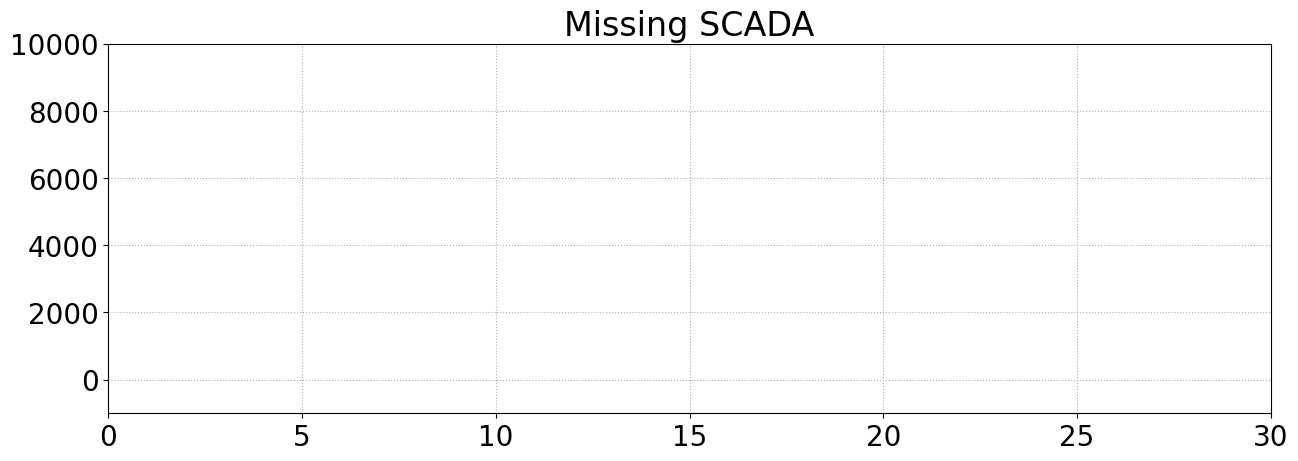

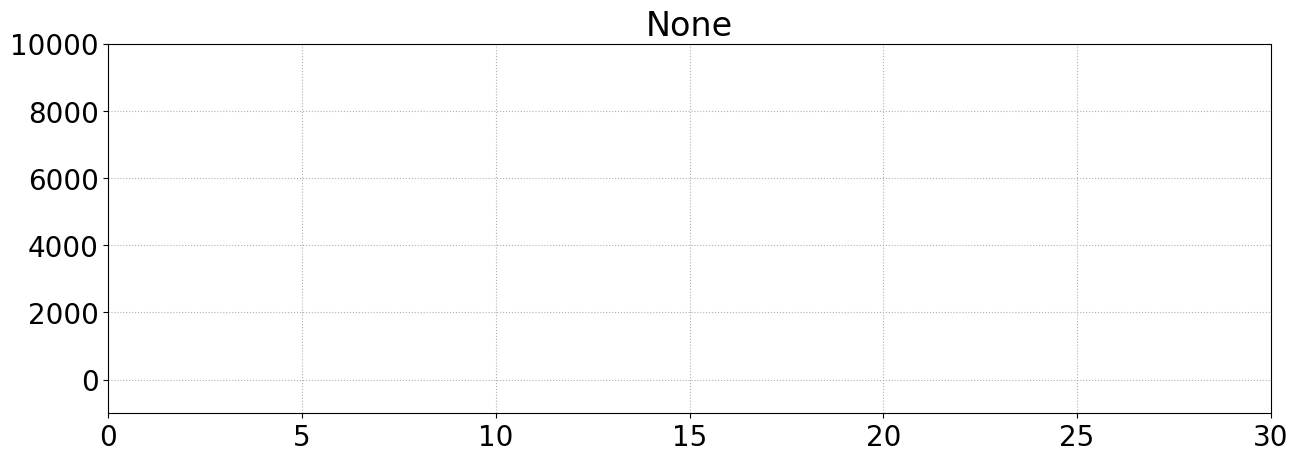

In [20]:
for caseID in dwf_.case_stats().index:
    dwf_[dwf_['caseID'] == caseID].plot(x='mean_windspeed',y='mean_power', marker='.', linestyle='')
    plt.title(caseID)
    plt.xlim(0,30)
    plt.ylim(-1000,10000)
    plt.gcf().set_figwidth(15)
    plt.show()

In [25]:
colors = [c.color for c in dwf_.case_definitions]

In [27]:
dwf_.case_definitions

[parked: Turbine parked, pitched at >87, rotating at less than 0.4RPM,
 pitch:78: Turbine pitched at 78deg.,
 idling: Generic idling (no constraint on pitch),
 cutin: Turbine speeding up to operational speeds,
 cutin (pitch > 20): Turbine speeding up to operational speeds,
 rpm<6.6: Turbine rotating up to 6.6RPM,
 rpm6.6: Turbine rotating at 6.6 RPM,
 Rated power: Turbine at rated power (9525kW),
 rpm<Max: Turbine speeding up to rated RPM,
 Rated RPM: Turbine rotating at 10.4rpm or 10.445rpm,
 High wind: Turbine reducing output power at extreme wind speeds,
 Curtailed (All): Catchall for data points that fall out of the normal behaviour,
 Missing SCADA: SCADA required to define cases is (partially) missing]

In [26]:
colors

['limegreen',
 'chartreuse',
 'forestgreen',
 'mediumseagreen',
 'springgreen',
 'teal',
 'gold',
 'firebrick',
 'tomato',
 'peru',
 'purple',
 'dodgerblue',
 'black']